In [20]:
import sys
import os
from pathlib import Path
import pandas as pd
import sys

import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
processed_series_path = Path(parent_dir) / 'processed_series'
generated_series_path = Path(parent_dir) / 'generated_series'
figure_save_path = Path(parent_dir) / 'figures'
if not figure_save_path.exists():
    os.makedirs(figure_save_path)

import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from models.ICL import MultiResolutionPDF
import sys
import torch

import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
sys.path.append("../models")

In [21]:
generated_series_path = Path('.') / 'generated_series'
generated_series_files = sorted([path for path in generated_series_path.iterdir()], key=lambda x: x.name)


In [22]:
# for i, name in enumerate(generated_series_files):
#     print(f"[{i}] {name}")
    
with open(generated_series_files[199], 'rb') as file:
    series_dict = pickle.load(file)

time_series = series_dict['time_series']

In [162]:

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)  # Third layer
        self.fc4 = nn.Linear(hidden_size3, output_size)  # Adjusted final layer
        self.activation = nn.LeakyReLU()  # Shared activation function
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        output = self.fc4(x)  # Note: No activation after the last layer if it's meant for a classification output layer
        return output

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
    
model = SimpleNN(input_size=1, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=2).to(device)
time_series = torch.tensor(time_series, dtype=torch.float32).to(device)
def NN_AR1_with_sigma(model, time_series, epochs=100, lr=0.001, patience=10):
    # time_series = np.asarray(time_series, dtype=np.float32)
    X_tensor = time_series[:-1].reshape(-1, 1)
    Y_tensor = time_series[1:].reshape(-1)  
    print(X_tensor.shape)
    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X_tensor)
        mu, log_sigma = outputs[:, 0], outputs[:, 1]
        sigma = torch.exp(log_sigma)
        # Negative log likelihood
        loss = torch.mean(log_sigma + 0.5 * ((Y_tensor - mu) ** 2) / sigma**2)
        # loss = torch.mean((Y_tensor - mu) ** 2) 
        loss.backward()
        optimizer.step()
        
        # Check for early stopping
        if loss < best_loss:
            best_loss = loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                # print(f'Early stop at epoch {epoch+1}')
                break
            
        if (epoch+1) % 10 == 0:            
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Predict the next state
    model.eval()
    with torch.no_grad():
        last_x = time_series[-1].reshape(-1, 1)
        pred = model(last_x)
        mu, log_sigma = pred[0][0].item(), pred[0][1].item()
        sigma = np.exp(log_sigma)
    
    return mu, sigma

CUDA is available. Using GPU.


/tmp/ipykernel_675916/3047657646.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series = torch.tensor(time_series, dtype=torch.float32).to(device)


In [163]:
NN_AR1_with_sigma(model, time_series, epochs=1000, lr=0.001, patience=30)

torch.Size([999, 1])
Epoch [10/1000], Loss: 0.2006
Epoch [20/1000], Loss: 0.0100
Epoch [30/1000], Loss: -0.2550
Epoch [40/1000], Loss: -0.5011
Epoch [50/1000], Loss: -0.6672
Epoch [60/1000], Loss: -0.7287
Epoch [70/1000], Loss: -0.7885
Epoch [80/1000], Loss: -0.8341
Epoch [90/1000], Loss: -0.8931
Epoch [100/1000], Loss: -0.9721
Epoch [110/1000], Loss: -1.0841
Epoch [120/1000], Loss: -1.2591
Epoch [130/1000], Loss: -1.5970
Epoch [140/1000], Loss: -2.1235
Epoch [150/1000], Loss: -2.2084
Epoch [160/1000], Loss: -2.3193
Epoch [170/1000], Loss: -2.4316
Epoch [180/1000], Loss: -2.5354
Epoch [190/1000], Loss: -2.6164
Epoch [200/1000], Loss: -2.6799
Epoch [210/1000], Loss: -2.7131
Epoch [220/1000], Loss: -2.7437
Epoch [230/1000], Loss: -2.7978
Epoch [240/1000], Loss: -2.8229
Epoch [250/1000], Loss: -2.8810
Epoch [260/1000], Loss: -2.9087
Epoch [270/1000], Loss: -2.9385
Epoch [280/1000], Loss: -2.9611
Epoch [290/1000], Loss: -2.9821
Epoch [300/1000], Loss: -2.9818
Epoch [310/1000], Loss: -3.015

(0.013180372305214405, 0.06663750318084292)

In [159]:
model.eval()
input = torch.tensor(time_series[:-1], dtype=torch.float32).reshape(-1,1)
output = model(input).cpu().detach().numpy()
mu = output[:,0]
log_sigma = output[:,1]



/tmp/ipykernel_675916/382513105.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(time_series[:-1], dtype=torch.float32).reshape(-1,1)


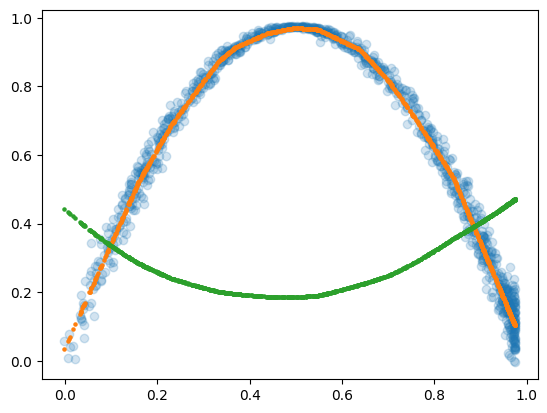

In [161]:
plt.scatter(time_series[:-1].cpu(),time_series[1:].cpu(), alpha = 0.2)
plt.scatter(time_series[:-1].cpu(),mu , s=5)
plt.scatter(time_series[:-1].cpu(),np.exp(log_sigma)*10 , s=5)